In [228]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap
import umap.umap_ as umap
import warnings

In [31]:
# Chargez le fichier CSV dans un DataFrame pandas
df = pd.read_csv("dataTp2.csv")

# Renommez la colonne 'Unnamed: 0' en 'internaute_id'
df.rename(columns={'Unnamed: 0': 'internaute_id'}, inplace=True)

# Affichez les premières lignes du DataFrame
df.head()

,internaute_id,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment
0,2157,0.501000,0.405000,0.407000,0.320000,0.365000,0
1,1223,0.497667,0.427000,0.408667,0.290000,0.378333,0
2,1083,0.460600,0.439800,0.421000,0.308400,0.406600,0
3,456,0.498000,0.454000,0.386000,0.379000,0.402000,0
4,1448,0.458818,0.483091,0.406909,0.297818,0.395273,0


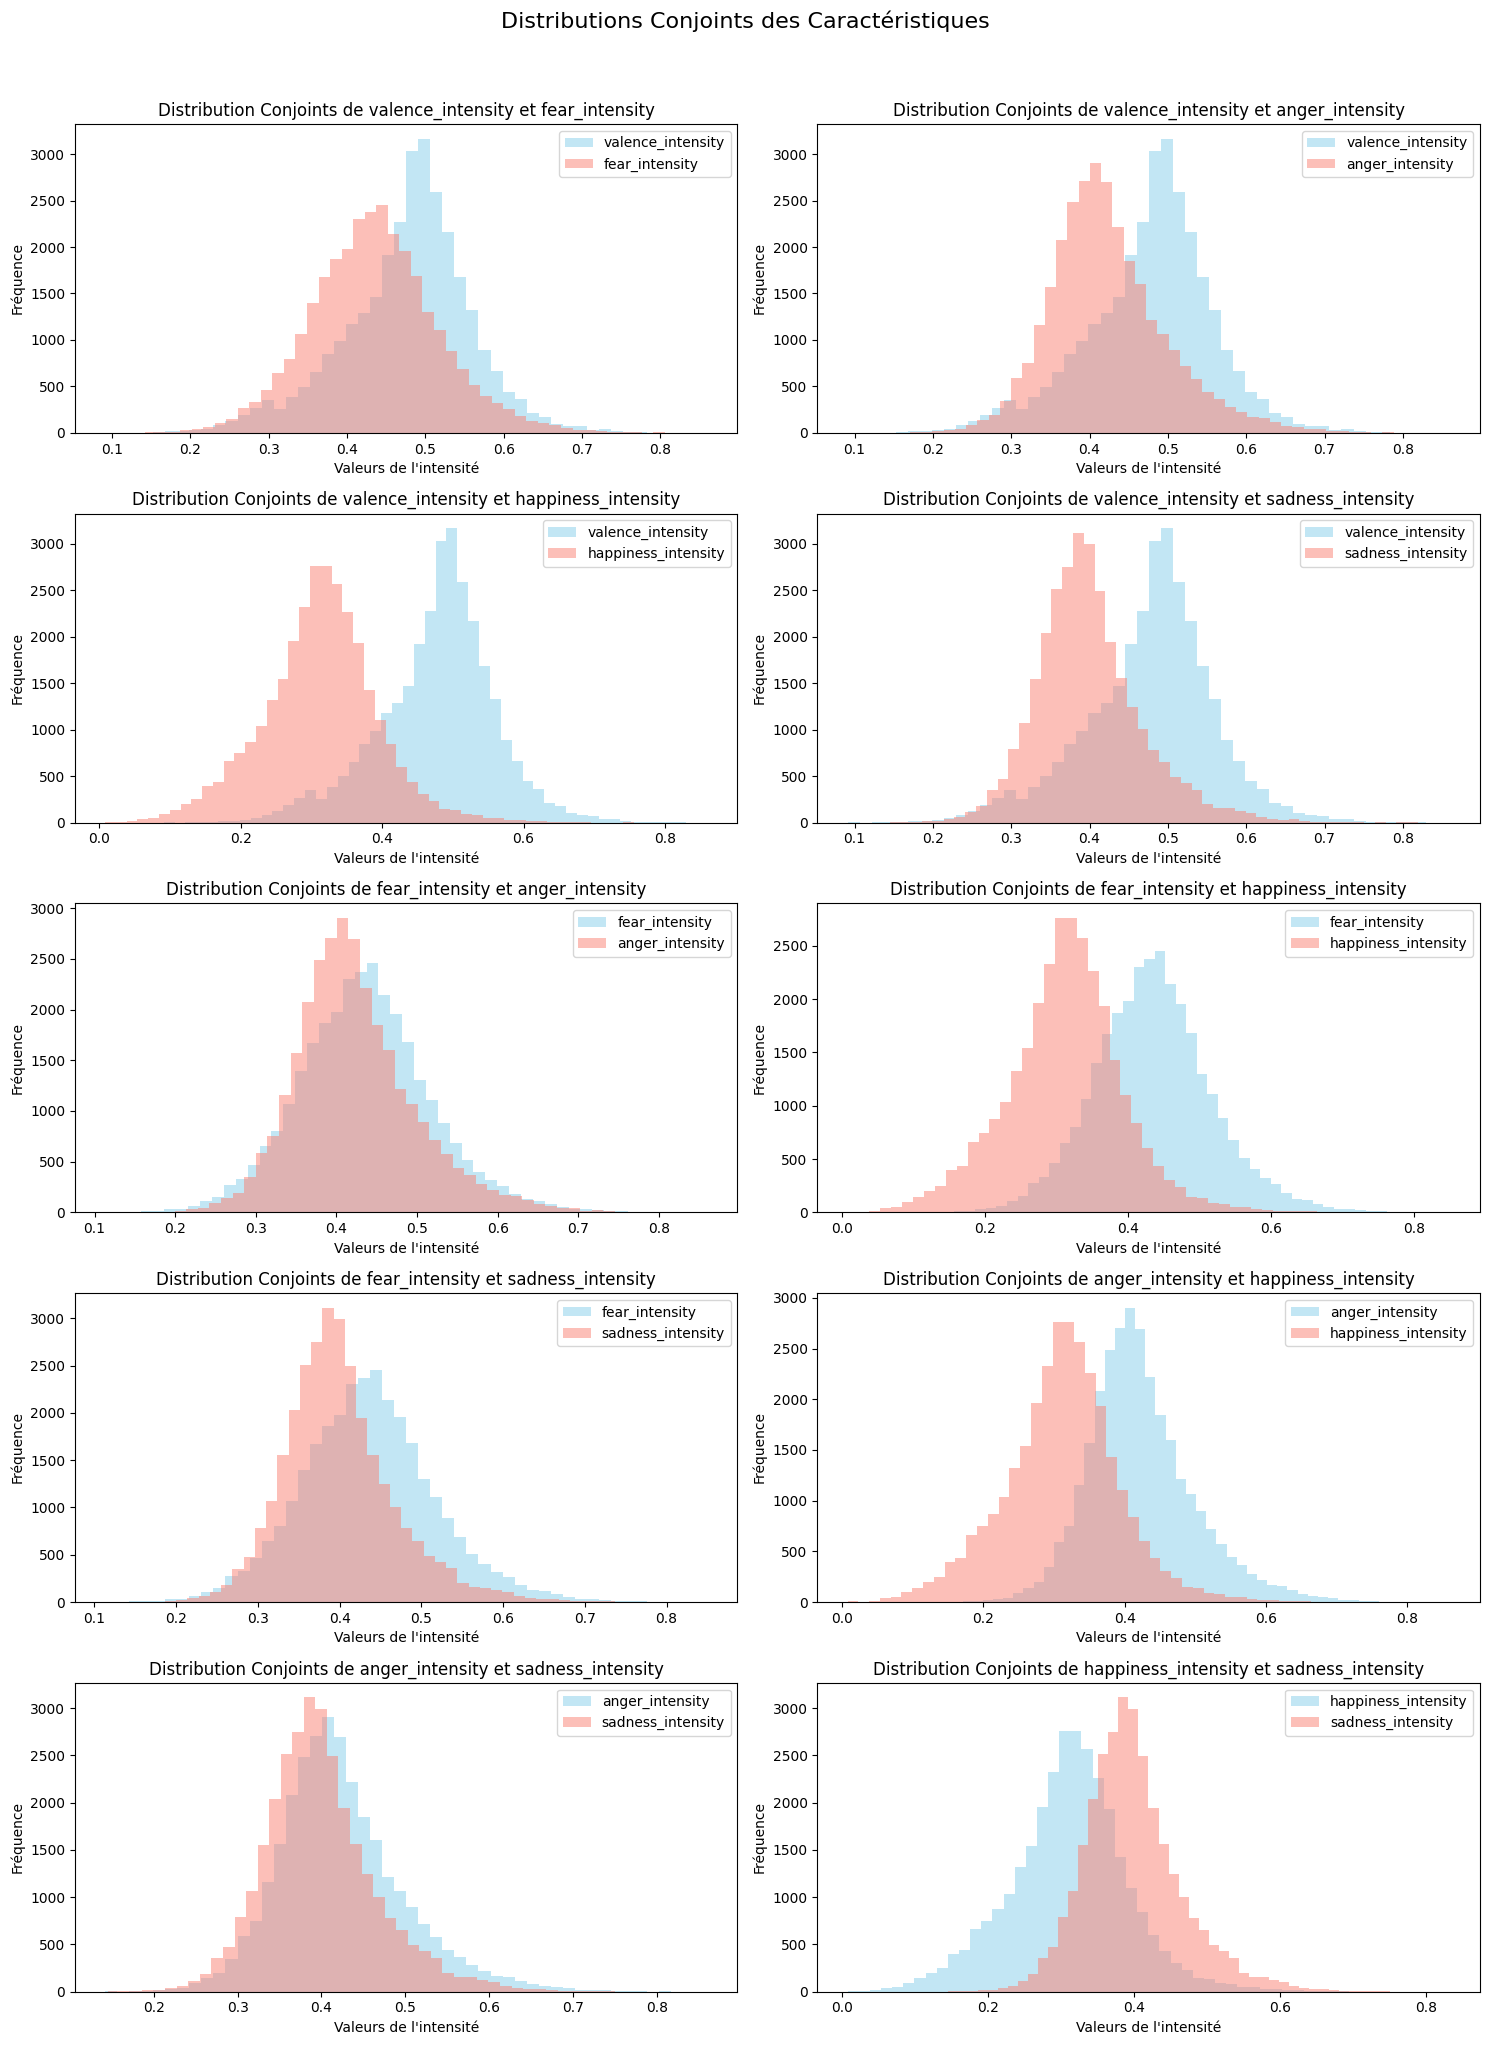

In [5]:
# Sélectionnez les caractéristiques pour les graphiques de distribution conjointe
caracteristiques_selectionnees = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']

# Créez toutes les paires possibles de caractéristiques
paires_de_caracteristiques = [(caracteristique1, caracteristique2) for i, caracteristique1 in enumerate(caracteristiques_selectionnees) for caracteristique2 in caracteristiques_selectionnees[i+1:]]

# Créez les histogrammes de distribution conjointe
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Distributions Conjoints des Caractéristiques', y=1.02, fontsize=16)

for i, (caracteristique1, caracteristique2) in enumerate(paires_de_caracteristiques):
    ligne, col = divmod(i, 2)
    
    # Tracé des histogrammes avec des couleurs différentes pour chaque caractéristique
    axes[ligne, col].hist(df[caracteristique1], bins=50, color='skyblue', alpha=0.5, label=caracteristique1)
    axes[ligne, col].hist(df[caracteristique2], bins=50, color='salmon', alpha=0.5, label=caracteristique2)
    
    axes[ligne, col].set_title(f'Distribution Conjoints de {caracteristique1} et {caracteristique2}')
    axes[ligne, col].set_xlabel('Valeurs de l\'intensité')
    axes[ligne, col].set_ylabel('Fréquence')
    axes[ligne, col].legend()

plt.tight_layout()
plt.show()

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

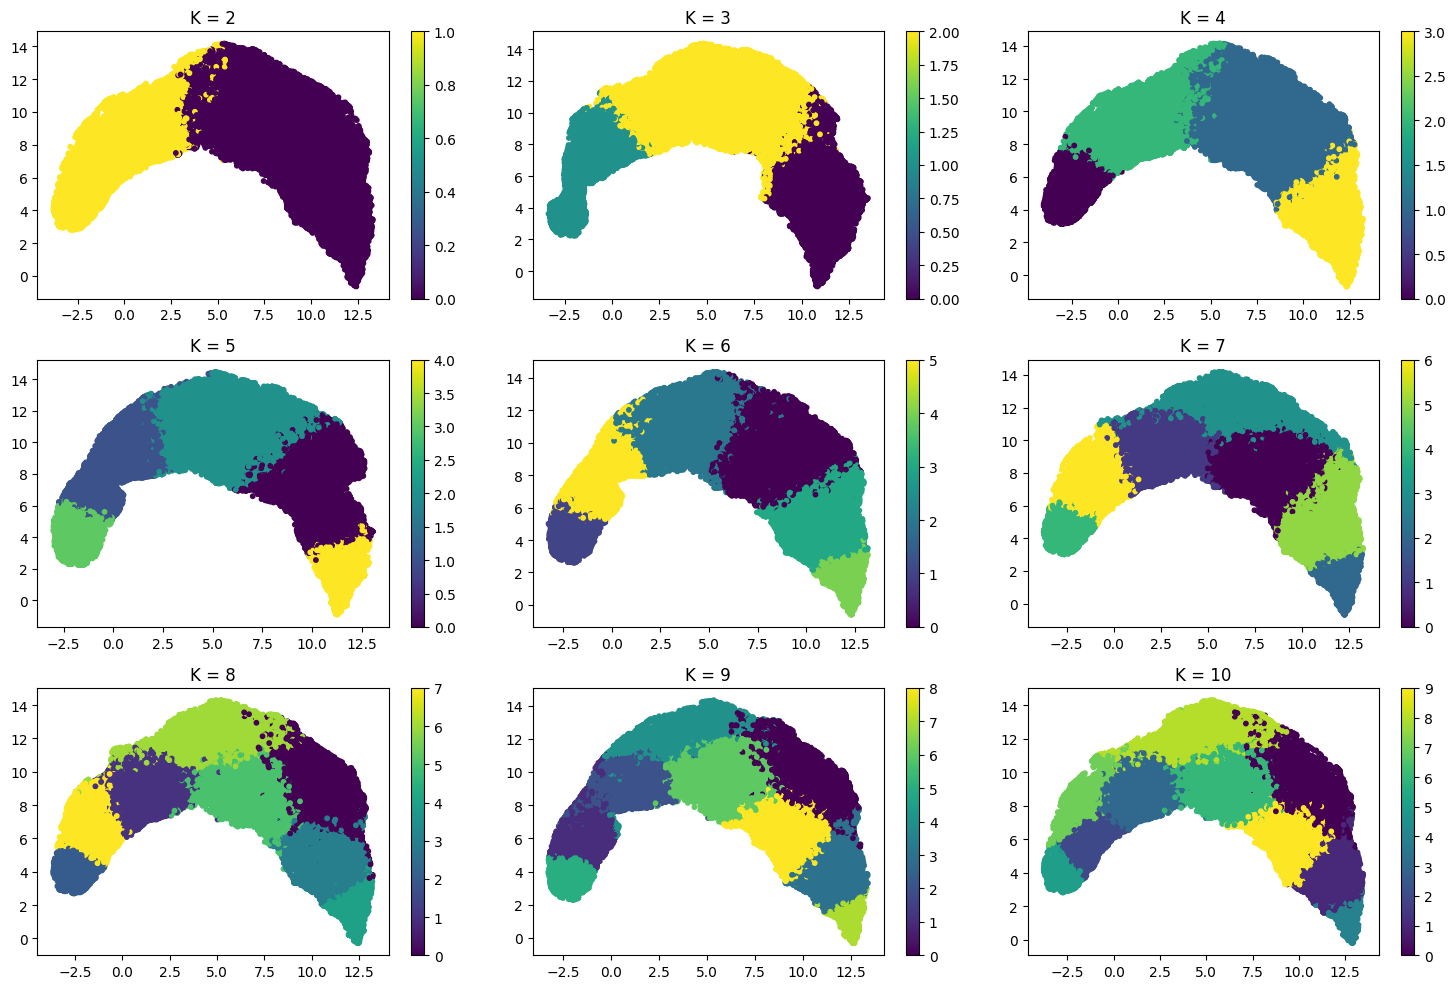

In [69]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sélectionner les caractéristiques pour l'analyse K-means
features = df[['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']]
# Appliquer K-means pour différentes valeurs de K
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = {}

plt.figure(figsize=(15, 10))

for i, k in enumerate(k_values, 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster_k{}'.format(k)] = kmeans.fit_predict(features)
    cluster_labels = df['cluster_k{}'.format(k)]
    silhouette_scores[k] = silhouette_score(features, cluster_labels)
    
    # Import UMAP from umap-learn
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)
    
    plt.subplot(3, 3, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=10)
    plt.title('K = {}'.format(k))
    plt.colorbar()

plt.tight_layout()
plt.show()

In [133]:
def cluster(k, nb_cluster):
    if nb_cluster >= k:
        raise ValueError("nb_cluster must be less than k")
    df_k = (df[f'cluster_k{k}'] == nb_cluster)
    return df[df_k][caracteristiques_selectionnees]

In [136]:
def calculate_cluster_centers(k, line=None):
    """
    Calculate the centers of the clusters for a given k.
    """
    centers = {}
    for cluster in range(k):
        df_k = (df[f'cluster_k{k}'] == cluster)
        cluster_data = df[df_k][caracteristiques_selectionnees]
        centers[cluster] = cluster_data.mean().values
    centers_df = pd.DataFrame(centers).T
    if line is not None:
        return centers_df.iloc[line]
    return centers_df

In [169]:
from sklearn.metrics import pairwise_distances
from itertools import combinations

In [157]:
def calculate_intra_cluster_distance(k, nb_cluster, distance_type='euclidean'):
    cluster_data = cluster(k, nb_cluster)
    cluster_center = calculate_cluster_centers(k, nb_cluster).values.reshape(1, -1)
    
    # Calculate the distances from all points in the cluster to the cluster center
    distances = pairwise_distances(cluster_data, cluster_center, metric=distance_type)
    
    # Return the maximum distance (which represents the intra-cluster distance)
    return distances.max()

In [159]:
def calculate_inter_cluster_distance(k, nb_cluster1, nb_cluster2, distance_type='euclidean'):
    
    cluster_data1 = cluster(k, nb_cluster1)
    center_1 = calculate_cluster_centers(k, nb_cluster1).values.reshape(1, -1)
    
    cluster_data2 = cluster(k, nb_cluster2)
    center_2 = calculate_cluster_centers(k, nb_cluster2).values.reshape(1, -1)
    
    # Calculate the distances from the center of cluster 1 to all points in cluster 2
    distances_1_to_2 = pairwise_distances(center_1, cluster_data2, metric=distance_type)
    
    # Calculate the distances from the center of cluster 2 to all points in cluster 1
    distances_2_to_1 = pairwise_distances(center_2, cluster_data1, metric=distance_type)
    
    # Return the minimum distance between the two sets of distances
    return min(distances_1_to_2.min(), distances_2_to_1.min())

In [197]:
def overlap_k(k, nb_cluster1 , nb_cluster2, distance_type='euclidean'):
    num = calculate_intra_cluster_distance(k, nb_cluster1, distance_type) + calculate_intra_cluster_distance(k, nb_cluster2, distance_type)
    den = 2 * calculate_inter_cluster_distance(k, nb_cluster1, nb_cluster2, distance_type)
    return num / den

In [213]:
def overlap(k, distance_type='euclidean'):
    
    max_overlap = 0

    # Generate all combinations of cluster pairs for the given k
    for cluster_pair in combinations(range(k), 2):
        nb_cluster1, nb_cluster2 = cluster_pair

        # Calculate the overlap for the current pair of clusters
        overlap_value = overlap_k(k, nb_cluster1, nb_cluster2, distance_type)

        # Update the maximum overlap if necessary
        if overlap_value > max_overlap:
            max_overlap = overlap_value

    return max_overlap

In [221]:
overlap_scores = {}

for i, k in enumerate(k_values, 1):
    overlap_scores[k] = overlap(k)

### Question 3

In [225]:
pd.DataFrame.from_dict(silhouette_scores, orient='index', columns=['Silhouette Score'])
overlap_df = pd.DataFrame.from_dict(overlap_scores, orient='index', columns=['Overlap Score'])
silhouette_df = pd.DataFrame.from_dict(silhouette_scores, orient='index', columns=['Silhouette Score'])

merged_df = pd.concat([overlap_df, silhouette_df], axis=1)
merged_df

,Overlap Score,Silhouette Score
2,4.397050,0.430988
3,4.487843,0.342330
4,4.535451,0.297912
5,4.495893,0.261714
6,5.741882,0.214229
7,5.525862,0.204650
8,4.975274,0.200402
9,4.886305,0.195605
10,4.919492,0.194996


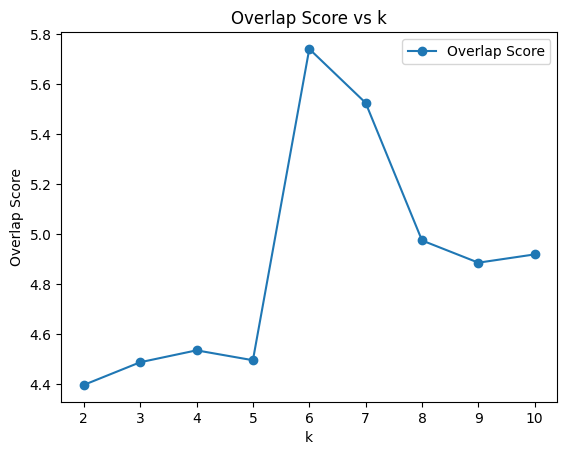

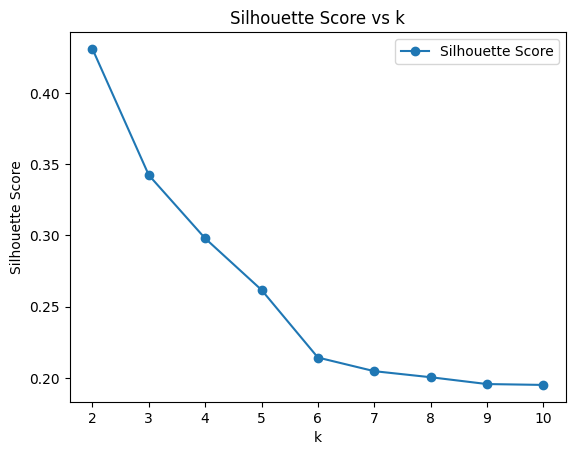

In [227]:
merged_df.plot(y='Overlap Score', marker='o')
plt.xlabel('k')
plt.ylabel('Overlap Score')
plt.title('Overlap Score vs k')
plt.show()
merged_df.plot(y='Silhouette Score', marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()
